<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/nisar/Flood_NISAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAR Application: Flooding

### Corresponding Story Map: https://arcg.is/19XXGW0
### I. How to create SAR quicklook images of flooding?

* Useful Products: HH, HV, and VV (if possible) polarizations. In forests, HH tends to pentrate further than VV. HV is more sensitive to volume scattering or to vegetation cover and biomass.
* Useful Wavelengths: L, S, C
  * Generally, longer wavelengths have greater penetration through the vegetation canopy, and the area's composition of tall and short flooded vegetation can help determine the best wavelength to use. For example, in a flooded forest, L-Band  is suited to detect inundation beneath the canopy. C and S band have reduced penetration capabilities but may be better suited for less densely vegetated areas of different conditions such as "leaf off." C-Band is better for patty rice cultivation and herbaceous wetlands.
* Instructions to View: Pauli decomposition for quad-pol or HH/HV, VV/VH for dual-pol images
* How does the user know the SAR data contains and is sensitive to flooding:
  * flood stage and flood area extent during acquisition, flooded grasses vs. flooded trees vs. open water, and the number of flood days

### II. How to interpret L-Band SAR images of flooding?
To identify areas of flooding, compare the SAR RGB image before and after the flood. Co-pol signal is relatively stronger in inundated areas owing to double-bounce. L-band brightness increases over flooded forests and tall vegetation, while short vegetation and open water will appear dark. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is little radar backscatter. SAR data's advantage is its ability to penetrate the vegetation canopy and its sensitivity to standing water under vegetation.

Backscatter Mechanisms:
- Specular or Surface Scattering: when there is a smooth surface, such as open water. In specular scattering, the signal scatters away from the radar. As a result, open water appears dark in the image. (HH or VV)
- Rough Scattering: slight roughness, where some but not all of the signal scatters away from the radar. This could be due to wind roughening or some vegetation.
- Volume Scattering (HV)
- Double Bounce: most of the signal is returned to the sensor, and these areas appear very bright in the image. This occurs in areas of flooded vegetation because of the interaction of the smooth water surface and vertical vegetation. Two smooth surfaces creating right angles.

## SAR Example: Hurricane Florence Flooding
Hurricane Florence was a category 4 hurricane from August 31 through September 18, 2018 that caused significant freshwater and storm surge flooding along the southeastern coast of the Carolinas. From September 17 through September 23, UAVSAR (L-Band airborne radar and NISAR testbed instrument) flew five times over the Pee Dee River in South Carolina to collect data during and after the hurricane. This Notebook will look at flooding changes during these acquistions.

The content of this notebook is as follows:
0. [Running the Notebook](#s1)
1. [Compare HH and HV September 17 vs September 23 2018](#s2)
2. [NISAR Simulated Products](#s3)
3. [Create HH Flooding Map](#s4)
4. [Coherence](#s5)

<a name="s1"></a>
## 0. Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.

### Python Packages:
This routine using the following python libaries. Some are already included in the Google Colab environment and others are installed in the cell below. Downloading new python packages to this environment may take a few minutes to complete.


In [1]:
# Installing rasterio to Google Colab environment. May take a few minutes to run.
!pip install rasterio --quiet
!pip install earthpy --quiet

import numpy as np              # Numeric and mathematic functions
import rasterio as rio          # Read and write geospatial raster data
import matplotlib.pyplot as plt # Plotting, making graphs
from rasterio.plot import show  # Rasterio plotting
import math

from matplotlib.colors import ListedColormap  # For selecting colors that correspond to image pixels
import matplotlib.colors as colors            # Used for color normalization
import earthpy.plot as ep                     # Allows plotting of mapped raster/vector data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.9 MB/s eta 0:00:00


### Download the Data

Fetch UAVSAR geotiffs from the download links below with wget. The original UAVSAR data have been converted to cropped and subset geotiffs.


In [14]:
## UAVSAR
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_180920_180922_L090HH_01_subset.cor.tif --quiet

## NISAR Simulated
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090HHHH_CG_138A_03_lee_5_1.tif
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090HHHH_CG_138A_02_lee_5_1.tif

--2024-01-04 19:00:07--  https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090HHHH_CG_138A_03_lee_5_1.tif
Resolving uavsar.jpl.nasa.gov (uavsar.jpl.nasa.gov)... 137.78.249.121
Connecting to uavsar.jpl.nasa.gov (uavsar.jpl.nasa.gov)|137.78.249.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5727334 (5.5M) [image/tiff]
Saving to: ‘peedee_15100_18064_002_180917_L090HHHH_CG_138A_03_lee_5_1.tif’

peedee_15100_18064_ 100%[===================>]   5.46M  5.28MB/s    in 1.0s    

2024-01-04 19:00:08 (5.28 MB/s) - ‘peedee_15100_18064_002_180917_L090HHHH_CG_138A_03_lee_5_1.tif’ saved [5727334/5727334]

--2024-01-04 19:00:09--  https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090HHHH_CG_138A_02_lee_5_1.tif
Resolving uavsar.jpl.nasa.gov (uavsar.jpl.nasa.gov)... 137.78.249.121
Connecting to uavsar.jpl.nasa.gov (uavsar.jpl.nasa.gov)|137.78.249.121|:443... connected.
HTTP request sent, awaiting response... 200 OK


<a name="s2"></a>
## 1. Hurricane Florence: Compare HH, HV, and VV during flooding (September 17, 2018 vs. September 23, 2018)

Read in the UAVSAR HH and HV images from September 17th (during beginning of flooding) and from September 23rd (after flooding).

Convert to decibels (dB) and remove any no data values.


In [3]:
def read_file(path):
    with rio.open(path) as ds:
        band = ds.read(1, masked=True)  # Read the band with nodata values as masked array
    return band

def convert_to_db(data):
    db_data = 10 * np.log10(data)
    return db_data

HH17 = read_file('peedee_15100_18064_002_180917_L090HHHH_CX_01.grd.tif')
HV17 = read_file('peedee_15100_18064_002_180917_L090HVHV_CX_01.grd.tif')
HH23 = read_file('peedee_15100_18069_007_180923_L090HHHH_CX_01.grd.tif')
HV23 = read_file('peedee_15100_18069_007_180923_L090HVHV_CX_01.grd.tif')

# Convert to decibels (dB) only for non-masked values
HH17 = convert_to_db(HH17.filled(np.nan))
HH23 = convert_to_db(HH23.filled(np.nan))
HV17 = convert_to_db(HV17.filled(np.nan))
HV23 = convert_to_db(HV23.filled(np.nan))

This next section plots HH and HV polarizations for September 17th and September 23rd.

The top rows shows the polarizations for September 17th and the bottom row shows September 23rd over a portion of the Pee Dee River, flooding around the river, and adjacent agricultural fields. These plots highlight changes between the two dates and differences in each polarizations' sensitivity to flooding.

In the HH polarization, open water and flooded agricultural fields appear dark and inundated vegetation is bright. The HV polarization does not show the same changes in inundation vegetation areas.


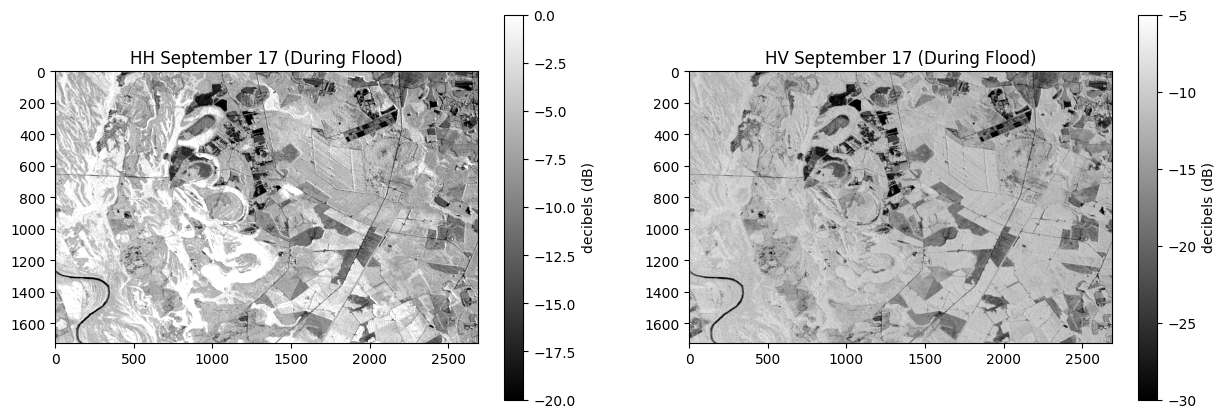

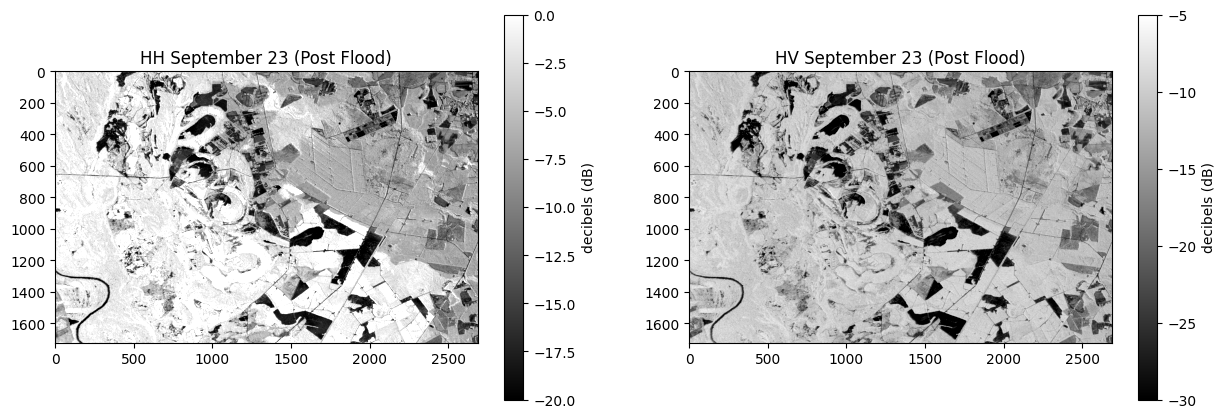

In [4]:
#@title Subset of Hurricane Florence Flooding Along the Pee Dee River

## September 17
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

vmin_HH = -20
vmax_HH = 0
vmin_HV = -30
vmax_HV = -5

HH17_plt = ax1.imshow(HH17, vmin=vmin_HH, vmax=vmax_HH, cmap="gray")
ax1.set_title('HH September 17 (During Flood)')
cbar=fig.colorbar(HH17_plt, ax=ax1, shrink=0.5)
cbar.set_label('decibels (dB)')

HV17_plt = ax2.imshow(HV17, vmin=vmin_HV, vmax=vmax_HV, cmap="gray")
ax2.set_title('HV September 17 (During Flood)')
cbar=fig.colorbar(HV17_plt, ax=ax2, shrink=0.5)
cbar.set_label('decibels (dB)')

## September 23
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 10))

HH23_plt = ax3.imshow(HH23, vmin=vmin_HH, vmax=vmax_HH, cmap="gray")
ax3.set_title('HH September 23 (Post Flood)')
cbar=fig.colorbar(HH23_plt, ax=ax3, shrink=0.5)
cbar.set_label('decibels (dB)')

HV23_plt = ax4.imshow(HV23, vmin=vmin_HV, vmax=vmax_HV, cmap="gray")
ax4.set_title('HV September 23 (Post Flood)')
cbar=fig.colorbar(HV23_plt, ax=ax4, shrink=0.5)
cbar.set_label('decibels (dB)')


The next portion plots HH and HV Histograms for the above subsets of HH and HV polarizations for September 17th and September 23rd.

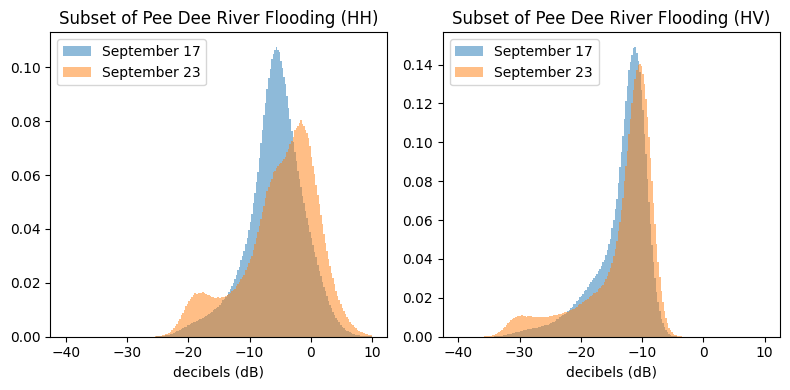

In [5]:
n = 200
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2)

polarization = ['HH', 'HV']

ax1.hist(HH17.flatten(),range = [-40, 10],density=True, bins=n, alpha=0.5, label='September 17')
ax1.hist(HH23.flatten(),range = [-40, 10],density=True, bins=n, alpha=0.5, label='September 23')
ax1.set_title('Subset of Pee Dee River Flooding (HH)')
ax1.legend(prop={'size': 10})
ax1.set_xlabel('decibels (dB)')

## Clamp to same axis as Sept 17
ax2.hist(HV17.flatten(), range = [-40, 10],density=True, bins=n, alpha=0.5, label='September 17')
ax2.hist(HV23.flatten(), range = [-40, 10],density=True, bins=n, alpha=0.5, label='September 23')
ax2.set_title('Subset of Pee Dee River Flooding (HV)')
ax2.legend(prop={'size': 10})
ax2.set_xlabel('decibels (dB)')

fig.tight_layout()
plt.show()

<a name="s3"></a>
## 2. NISAR Simulated Products

The plot below displays NISAR simulated HH data for the same Pee Dee River coverage. NISAR simulated products are generated from UAVSAR data to emulate NISAR data characteristics in order to help users test their algorithms and get a sense of the quality of future NISAR products.
* To learn more about NISAR simulated data characteristics go here: https://uavsar.jpl.nasa.gov/science/documents/nisar-sample-products.html and browse the other available NISAR simulated data by selecting "Simulated NISAR" on the UAVSAR data search page: https://uavsar.jpl.nasa.gov/cgi-bin/data.pl.
* To learn more about all the planned NISAR data products, a short description, a link to where you can download them, go here: https://nisar.jpl.nasa.gov/data/sample-data/

The modes below are dithered with gaps in the mode 138A (40 MHz)


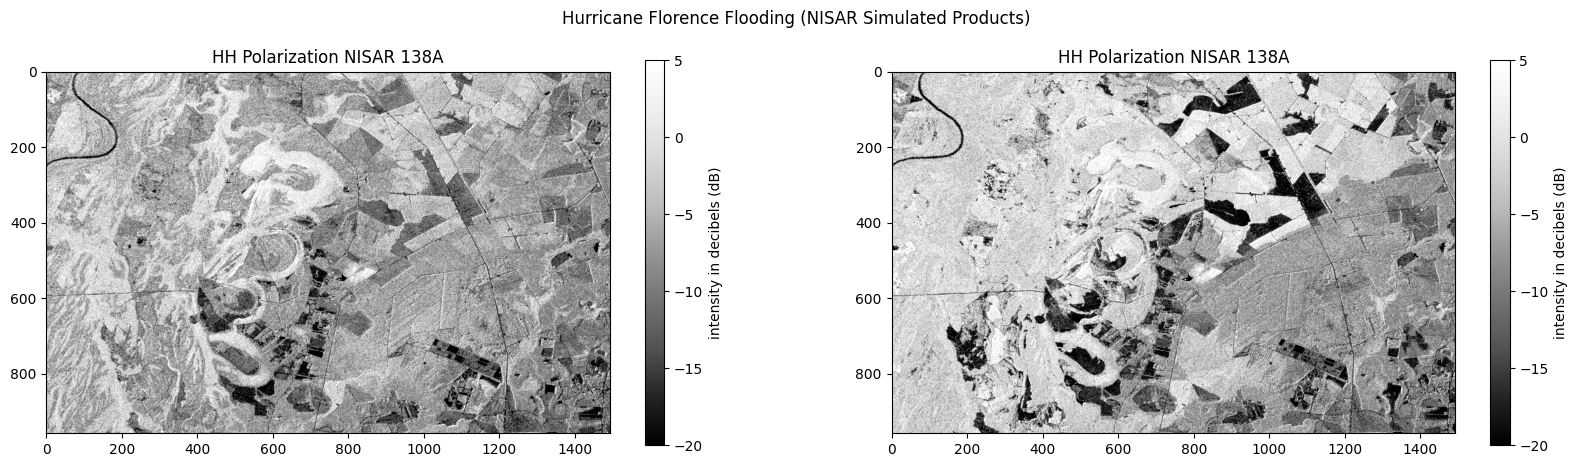

In [19]:
#@title Plot NISAR Simulated Images

## gulfco_32010 subset
peedee_Sept17_138A = read_file('/content/peedee_15100_18064_002_180917_L090HHHH_CG_138A_03_lee_5_1.tif')
peedee_Sept23_138A = read_file('/content/peedee_15100_18069_007_180923_L090HHHH_CG_138A_02_lee_5_1.tif')


## Convert to decibels
peedee_Sept17_138A_db = convert_to_db(peedee_Sept17_138A)
peedee_Sept23_138A_db = convert_to_db(peedee_Sept23_138A)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Add general map title
fig.suptitle("Hurricane Florence Flooding (NISAR Simulated Products)")

HH_Sept17 = ax[0].imshow(peedee_Sept17_138A_db, vmin=-20, vmax=5, cmap="Greys_r")
ax[0].set_title('HH Polarization NISAR 138A')
cbar = fig.colorbar(HH_Sept17 , ax=ax[0])
cbar.set_label('intensity in decibels (dB)')

HH_Sept23 = ax[1].imshow(peedee_Sept23_138A_db, vmin=-20, vmax=5, cmap="Greys_r")
ax[1].set_title('HH Polarization NISAR 138A')
cbar = fig.colorbar(HH_Sept23, ax=ax[1])
cbar.set_label('intensity in decibels (dB)')

<a name="s4"></a>
## 3. Create Flood Map with HH

In [6]:
HH23_class = HH23.copy()
HH23_og = HH23.copy()

openwater_threshold = -15
flooding_threshold = -3

# Open Water
HH23_class[HH23_og < openwater_threshold] = 1
# Not Flooded
HH23_class[(HH23_og > openwater_threshold) & (HH23_og < flooding_threshold)] = 2
# Flooded
HH23_class[HH23_og > flooding_threshold] = 3

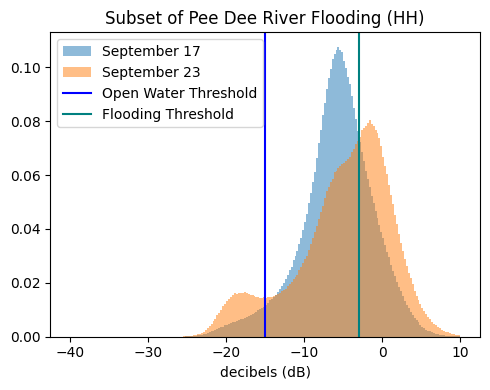

In [7]:
n = 200
fig, ax = plt.subplots(figsize=(5,4))

ax.hist(HH17.flatten(),range = [-40, 10],density=True, bins=n, alpha=0.5, label='September 17')
ax.hist(HH23.flatten(),range = [-40, 10],density=True, bins=n, alpha=0.5, label='September 23')
plt.axvline(x = openwater_threshold, color = 'blue', label = 'Open Water Threshold')
plt.axvline(x = flooding_threshold, color = 'teal', label = 'Flooding Threshold')
ax.set_title('Subset of Pee Dee River Flooding (HH)')
ax.legend(prop={'size': 10})
ax.set_xlabel('decibels (dB)')

fig.tight_layout()
plt.show()

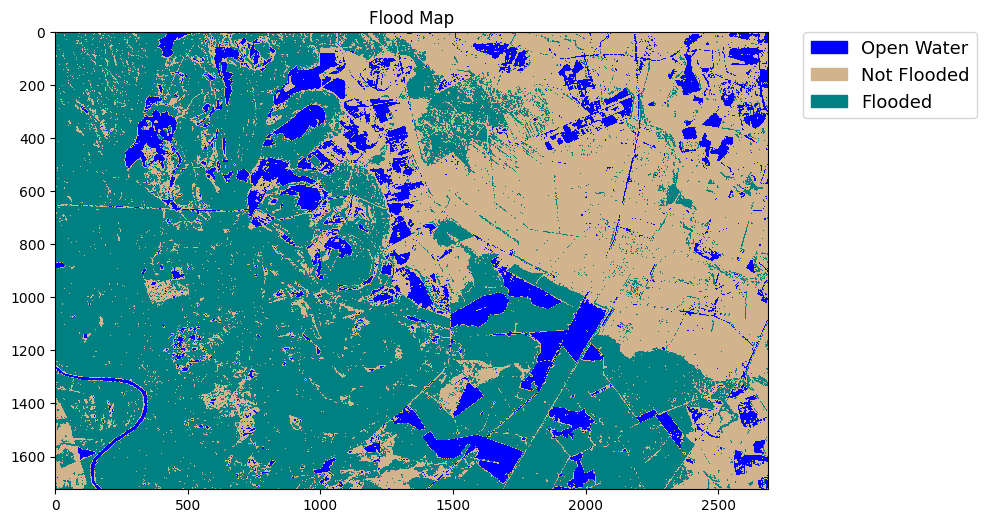

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

# Define the colors you want
cmap = ListedColormap(["blue", "tan", "teal"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)
im = ax.imshow(HH23_class, cmap = cmap)
ep.draw_legend(im, titles=["Open Water", "Not Flooded", "Flooded"], classes=[1, 2, 3])

# Add general map title
plt.title("Flood Map")
plt.tight_layout()

<a name="s5"></a>
## 4. Coherence

Instructions to View: Grayscale showing coherence 0-1; use the same scale for "before" and "after" image to facilitate comparison. Compare image pairs with increasing temporal separation up to a maximum that is determined empirically. After a number of days, the entire image is decorrelated.

Interpretation: Close to black: open water bodies that decorrelate the fastest. Dark gray= decorrelated due to flood. Mid-gray and white = areas where water level changes are not detected by SAR. This could still be saturated soil.

UAVSAR data product page: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=peedee_15100_18067-005_18068-005_0002d_s01_L090_01#data


Text(0.5, 1.0, 'Coherence from September 20 to September 22 (HH)')

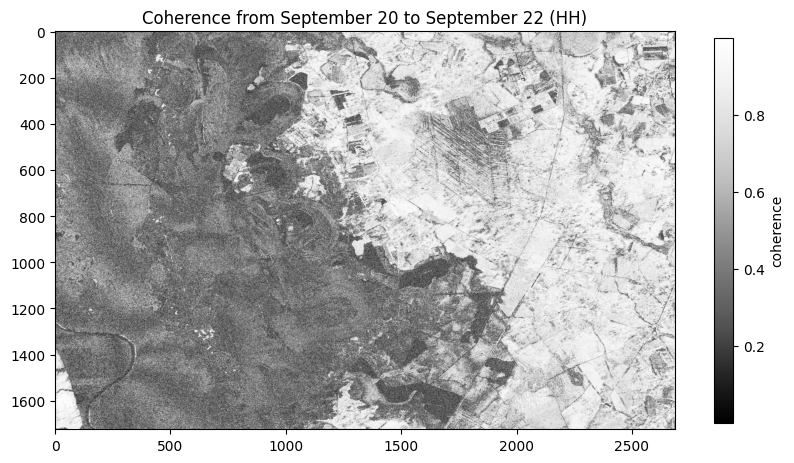

In [9]:
coherence = read_file("peedee_15100_180920_180922_L090HH_01_subset.cor.tif")
coherence[coherence == 0] = np.nan

fig, ax = plt.subplots(figsize=(10,10))
coherence_plt=plt.imshow(coherence, cmap="Greys_r")
cbar=fig.colorbar(coherence_plt, ax=ax, shrink=0.5)
cbar.set_label('coherence')
plt.title('Coherence from September 20 to September 22 (HH)')

In [10]:
coherence_data = coherence.copy()

change_threshold = 0.65

# Flooding Change
coherence_data[coherence < change_threshold] = 1
coherence_data[coherence >= change_threshold] = 2

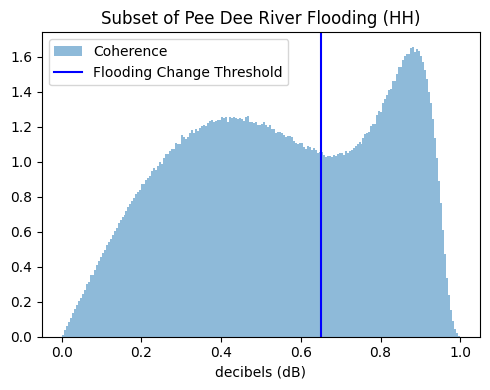

In [11]:
n = 200
fig, ax = plt.subplots(figsize=(5,4))

ax.hist(coherence.flatten(),density=True, bins=n, alpha=0.5, label='Coherence')
plt.axvline(x = change_threshold, color = 'blue', label = 'Flooding Change Threshold')
ax.set_title('Subset of Pee Dee River Flooding (HH)')
ax.legend(prop={'size': 10})
ax.set_xlabel('decibels (dB)')

fig.tight_layout()
plt.show()

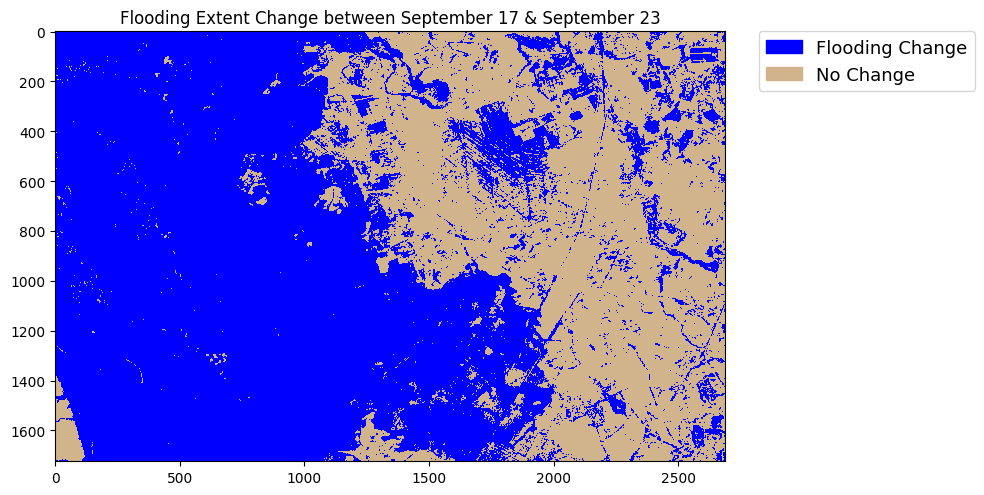

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

# Define the colors you want
cmap = ListedColormap(["blue", "tan"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)
im = ax.imshow(coherence_data, cmap = cmap)
ep.draw_legend(im, titles=["Flooding Change", "No Change"], classes=[1, 2])

# Add general map title
plt.title("Flooding Extent Change between September 17 & September 23")
plt.tight_layout()

## Data Download
Download UAVSAR line peedee_15100 https://uavsar.jpl.nasa.gov/cgi-bin/data.p

ASF: https://search.asf.alaska.edu/#/

UAVSAR website: https://uavsar.jpl.nasa.gov


## Other Resources
NISAR Flood Applications White Paper: https://nisar.jpl.nasa.gov/system/documents/files/5_NISAR_Applications_Floods.pdf

CEOS Document - A Layman’s Interpretation Guide to L-band and C-band Synthetic Aperture Radar data:
http://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf

ESA Radar Courses:
https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/ers/instruments/sar/applications/radar-courses

ESA Pauli Decomposition: https://earth.esa.int/documents/653194/656796/DIY_2_Representations_of_polarimetric_information.pdf

SERVIR Biomass:  https://www.servirglobal.net/Global/Articles/Article/2674/sar-handbook-comprehensive-methodologies-for-forest-monitoring-and-biomass-estimation

NASA ARSET: SAR for Flood Mapping (Slides: https://appliedsciences.nasa.gov/sites/default/files/SAR_Part1.pdf, Lecture Videos: https://appliedsciences.nasa.gov/join-mission/training/english/arset-sar-landcover-applications)

NASA ARSET: Introduction to SAR Remote Sensing (https://appliedsciences.nasa.gov/join-mission/training/english/arset-introduction-synthetic-aperture-radar)


## References
US Department of Commerce, NOAA. “Historical Hurricane Florence, September 12-15, 2018.” National Weather Service, NOAA's National Weather Service, www.weather.gov/mhx/Florence2018.

https://www.sciencedirect.com/science/article/pii/S0034425712004257

https://ui.adsabs.harvard.edu/abs/2019AGUFMIN53C0755M/abstract

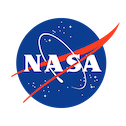

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2023. California Institute of Technology. Government sponsorship acknowledged.